In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/bev-generation


In [2]:
import os
from pathlib import Path
import itertools
from io import BytesIO
import time
import json

import numpy as np
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.neighbors import KNeighborsClassifier

from nuscenes.nuscenes import NuScenes

import lmdb

from tqdm import tqdm

import utils
from utils import bytes_to_array
import nusc_utils

from bev_gt import generate_gt_bev_map
from bev2 import BEV, generate_bev_seg_map

In [3]:
dataroot = Path('/Users/deepakduggirala/Documents/autonomous-robotics/v1.0-mini/').resolve()
nuscenes = NuScenes(version='v1.0-mini', dataroot=str(dataroot), verbose=False)
scene_idx = 0
sample_idx = 10

In [4]:
scene = nuscenes.scene[scene_idx]
sample = list(nusc_utils.sample_gen(nuscenes, scene))[sample_idx]

In [5]:
bev_seg_map, nusc_idx_to_color = generate_bev_seg_map(nuscenes, sample)

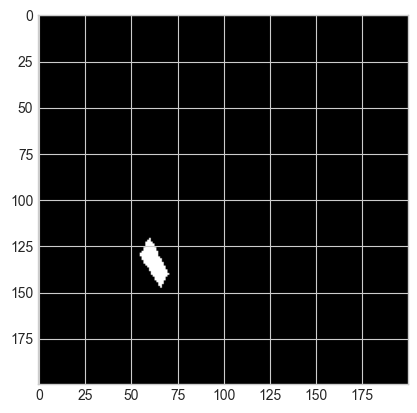

In [162]:
plt.imshow(bev_seg_map[2], cmap='gray')

In [43]:
xx, yy = np.meshgrid(np.arange(200), np.arange(200))
xi = np.hstack((yy.reshape(-1, 1), xx.reshape(-1, 1)))

In [198]:
idx=0
xx, yy = np.where(bev_seg_map[idx])
xy = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
c = bev_seg_map[idx, xx, yy].flatten()
xy.shape, c.shape

((3137, 2), (3137,))

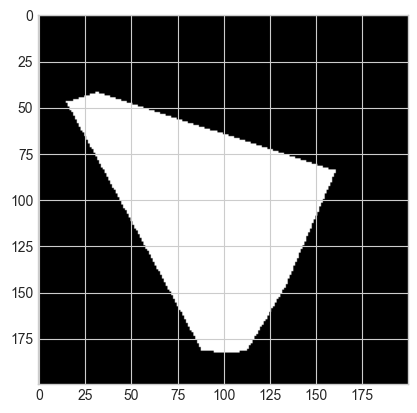

In [202]:
intp_cls = scipy.interpolate.griddata(
                points=xy,
                values=c,
                xi=xi,
                method='linear'
            )
plt.imshow(np.nan_to_num(intp_cls).reshape(200, 200), cmap='gray')

In [120]:
label_idxs = [i for i,x in enumerate(nusc_utils.NUSC_LIDAR_CLASS_NAMES) if i not in (1,3)]
label_idxs

[0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [174]:
cmp = utils.make_composite(bev_seg_map)

In [10]:
color_map = {i + 1: c for i, c in nusc_idx_to_color.items()}
color_map[0] = [255, 255, 255]
color_map[2] = [255, 255, 255]  # do not plot "other_flat"
color_map[4] = [255, 255, 255]  # do not plot "terrain"
color_map[15] = [255, 255, 255]  # do not plot "lidar mask"

In [204]:
xx, yy = np.where(cmp)
xy = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
c = cmp[xx, yy].flatten()
xy.shape, c.shape

((4514, 2), (4514,))

(-0.5, 199.5, 199.5, -0.5)

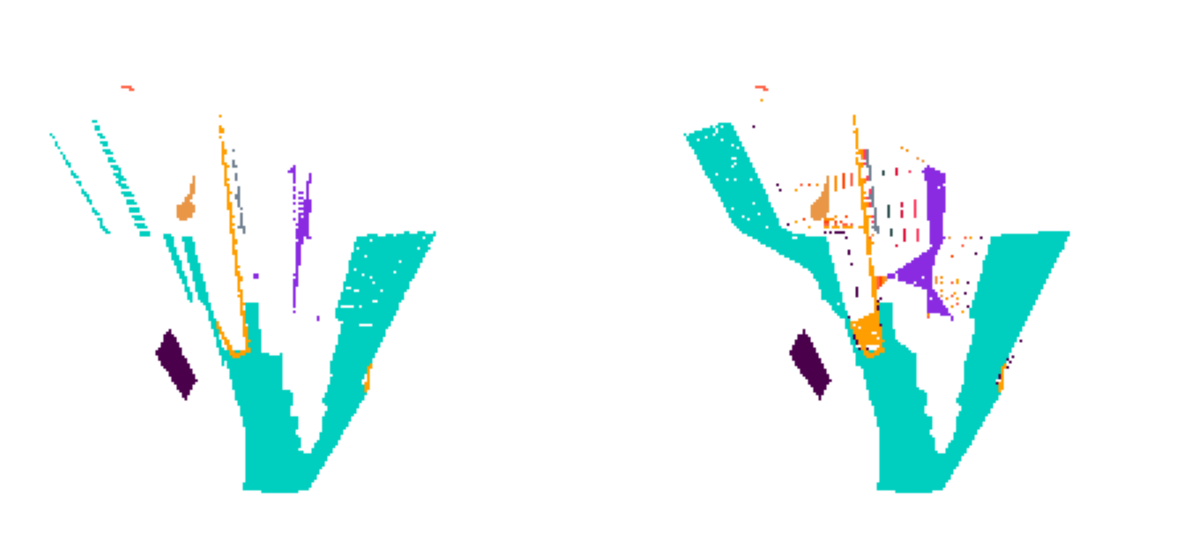

In [205]:
intp_cls = scipy.interpolate.griddata(
                points=xy,
                values=c,
                xi=xi,
                method='linear'
            )

cls_merged = np.array([int(cls_idx) if abs(cls_idx-np.round(cls_idx))==0 else 0 for cls_idx in np.nan_to_num(intp_cls)])

fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
axs[0].imshow(utils.color_components(cmp, color_map=color_map), cmap='twilight')
axs[1].imshow(utils.color_components(cls_merged.reshape(200, 200), color_map=color_map), cmap='twilight')

axs[0].axis('off')
axs[1].axis('off')

In [13]:
def interpolate_static_classes_bev(bev_seg_map):
    nc, H, W = bev_seg_map.shape
    xx, yy = np.meshgrid(np.arange(H), np.arange(W))
    xi = np.hstack((yy.reshape(-1, 1), xx.reshape(-1, 1)))

    for idx in [0,1,2,3]:
        xx, yy = np.where(bev_seg_map[idx])
        xy = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))
        c = bev_seg_map[idx, xx, yy].flatten()
        intp_cls = scipy.interpolate.griddata(
            points=xy,
            values=c,
            xi=xi,
            method='linear'
        )
        bev_seg_map[idx, :, :] = intp_cls.reshape(H, W)
        return bev_seg_map

In [18]:
bv_intp = interpolate_static_classes_bev(bev_seg_map)
cmp = utils.make_composite(bev_seg_map)

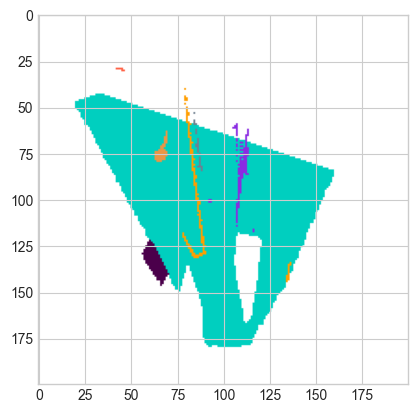

In [19]:
plt.imshow(utils.color_components(cmp, color_map=color_map))